# Notebook

Importing libraries

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import yaml

Reading files

In [8]:
try:
    with open('params.yml','r') as file:
        config = yaml.safe_load(file)  
except Exception as e:
    print('Error reading the config file')

In [9]:
config

{'raw_data': 'GroundTruth.csv'}

In [10]:
df=pd.read_csv(config['raw_data'])
print(df.shape)
df.head()


(10015, 8)


,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df['image']=df['image'].apply(lambda x: x+ '.jpg')
df.head()

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
df.to_csv('01_data/data.csv', index=False)

String to put images in folders (using GitBash)

In [12]:
s = ''
for n in range(0,len(df)):
    if df['VASC'][n] == 1:
        s += df['image'][n] + ' '

## Loading images

In [14]:
import pathlib

In [15]:
data_dir = pathlib.Path('C:/Users/joana/projects/skin/01_data')

In [16]:
data_dir

WindowsPath('C:/Users/joana/projects/skin/images_folder')

In [17]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

10015


In [18]:
df['image'][0]

'ISIC_0024306.jpg'

(450, 600, 3)


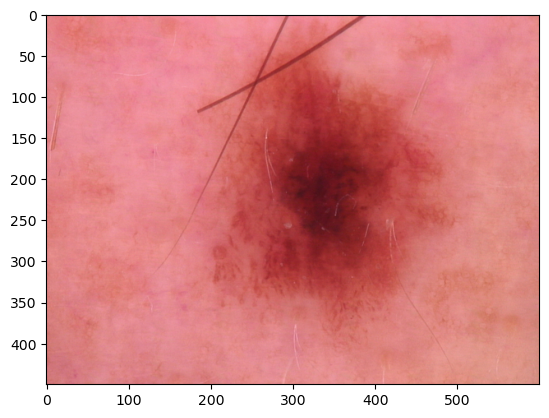

In [19]:
img=plt.imread('images_folder/NV/'+df['image'][0])
print (img.shape)
plt.imshow(img)

## Create dataset

In [20]:
batch_size = 32
img_height = 224
img_width = 224

### Splitting between train, validation and testing

In [21]:
train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10015 files belonging to 7 classes.
Using 7011 files for training.


In [22]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10015 files belonging to 7 classes.
Using 3004 files for validation.


Separating validation set into validation and test sets

In [23]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.skip((2*val_batches) // 3)
val_ds = val_ds.take((2*val_batches) // 3)

In [24]:
print('Batches for testing -->', test_ds.cardinality())
print('Batches for validating -->', val_ds.cardinality())

Batches for testing --> tf.Tensor(32, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(62, shape=(), dtype=int64)


In [25]:
class_names = train_ds.class_names
print(class_names)

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']


### Examples of each class

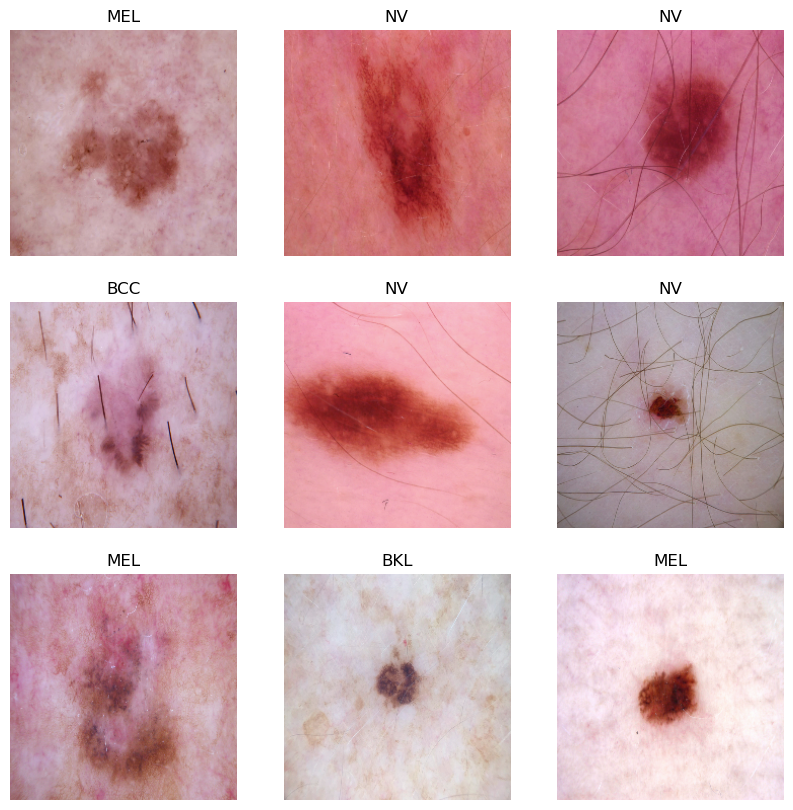

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [28]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Normalizing

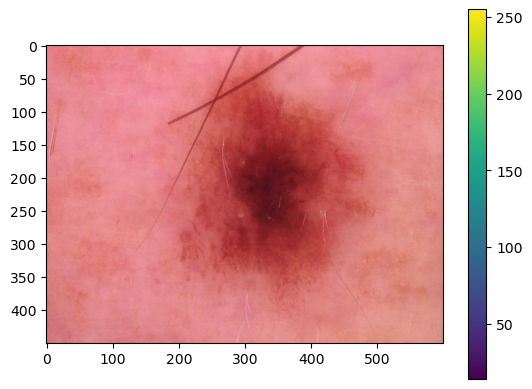

In [30]:
plt.figure()
plt.imshow(img)
plt.colorbar()
plt.grid(False)
plt.show()

Color values are in the [0, 255] range. Values will be rescaled to [0, 1] range.

## Model

In [31]:
num_classes = len(class_names)

In [37]:
tf.get_logger().setLevel('ERROR')

model = Sequential([
  #Image augmentation
  layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast([0,1], seed=57),
  layers.RandomBrightness(0.2, value_range=(0, 255), seed=57),
  layers.Rescaling(1./255),
  #layer 1
  layers.Conv2D(32,kernel_size=(3,3),activation='relu',),
  layers.MaxPooling2D(pool_size=(2,2)),
  #layer 2
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  #layer 3
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),
  #layer 4
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(pool_size=(2,2)),  
  
  #end
  layers.Flatten(),
  layers.Dropout(rate=0.3),
  layers.Dense(256, activation='relu'),
  layers.Dropout(rate=0.2),
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_contrast_2 (RandomCo  (None, 224, 224, 3)      0         
 ntrast)                                                         
                                                                 
 random_brightness (RandomBr  (None, 224, 224, 3)      0         
 ightness)                                                       
                                                      

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [39]:
epochs = 100

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100


C:\Users\joana\anaconda3\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


220/220 [==============================] - 557s 2s/step - loss: 1.0479 - accuracy: 0.6672 - val_loss: 0.9494 - val_accuracy: 0.6784
Epoch 2/100
220/220 [==============================] - 524s 2s/step - loss: 0.9349 - accuracy: 0.6802 - val_loss: 0.8756 - val_accuracy: 0.6855
Epoch 3/100
220/220 [==============================] - 525s 2s/step - loss: 0.8944 - accuracy: 0.6885 - val_loss: 0.8987 - val_accuracy: 0.6956
Epoch 4/100
220/220 [==============================] - 514s 2s/step - loss: 0.8602 - accuracy: 0.6953 - val_loss: 0.8166 - val_accuracy: 0.7016
Epoch 5/100
220/220 [==============================] - 518s 2s/step - loss: 0.8213 - accuracy: 0.7076 - val_loss: 0.8761 - val_accuracy: 0.6865
Epoch 6/100
220/220 [==============================] - 515s 2s/step - loss: 0.7964 - accuracy: 0.7133 - val_loss: 0.7919 - val_accuracy: 0.7273
Epoch 7/100
220/220 [==============================] - 513s 2s/step - loss: 0.7830 - accuracy: 0.7192 - val_loss: 0.7757 - val_accuracy: 0.7208
Epoc

Epoch 41/100
220/220 [==============================] - 610s 3s/step - loss: 0.5303 - accuracy: 0.8029 - val_loss: 0.6408 - val_accuracy: 0.7596
Epoch 42/100
220/220 [==============================] - 625s 3s/step - loss: 0.5295 - accuracy: 0.8035 - val_loss: 0.6485 - val_accuracy: 0.7631
Epoch 43/100
220/220 [==============================] - 635s 3s/step - loss: 0.5133 - accuracy: 0.8060 - val_loss: 0.6732 - val_accuracy: 0.7485
Epoch 44/100
220/220 [==============================] - 493s 2s/step - loss: 0.5063 - accuracy: 0.8100 - val_loss: 0.6345 - val_accuracy: 0.7656
Epoch 45/100
220/220 [==============================] - 490s 2s/step - loss: 0.5077 - accuracy: 0.8120 - val_loss: 0.6458 - val_accuracy: 0.7626
Epoch 46/100
220/220 [==============================] - 486s 2s/step - loss: 0.5010 - accuracy: 0.8114 - val_loss: 0.6747 - val_accuracy: 0.7495
Epoch 47/100
220/220 [==============================] - 491s 2s/step - loss: 0.5002 - accuracy: 0.8174 - val_loss: 0.6714 - val_ac

220/220 [==============================] - 492s 2s/step - loss: 0.2532 - accuracy: 0.9074 - val_loss: 0.7364 - val_accuracy: 0.7747
Epoch 98/100
220/220 [==============================] - 493s 2s/step - loss: 0.2493 - accuracy: 0.9051 - val_loss: 0.7647 - val_accuracy: 0.7661
Epoch 99/100
220/220 [==============================] - 505s 2s/step - loss: 0.2672 - accuracy: 0.9013 - val_loss: 0.7707 - val_accuracy: 0.7555
Epoch 100/100
220/220 [==============================] - 493s 2s/step - loss: 0.2439 - accuracy: 0.9080 - val_loss: 0.8013 - val_accuracy: 0.7591


In [42]:
%%writefile -a functions.py

def plot_acc_loss(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
%run functions.py

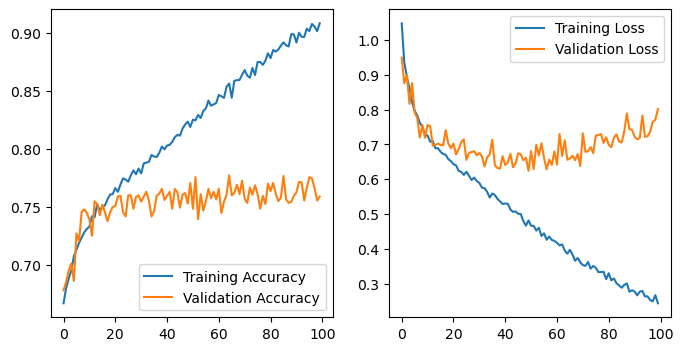

In [43]:
plot_acc_loss(history,epochs)

Saving model

In [40]:
model.save('model224_4.h5') # Saves the entire model to a single artifact

## Testing

In [44]:
predictions = model.predict(test_ds)
score = tf.nn.softmax(predictions)

32/32 [==============================] - 29s 557ms/step


In [46]:
y_test_pred = np.argmax(score, axis=-1)

In [55]:
y_test =  np.array([])
for x, y in test_ds:
    y_test = np.concatenate([y_test, y.numpy()])

In [56]:
class_names

['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

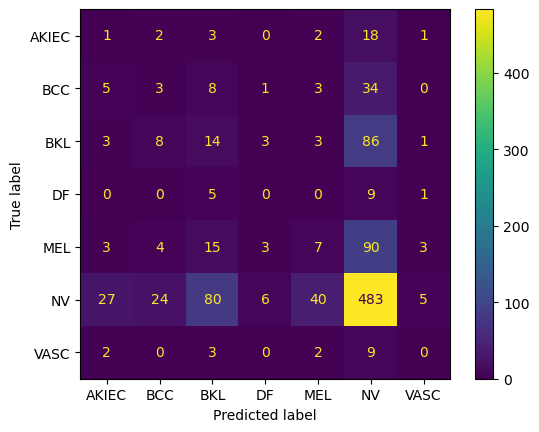

In [57]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_mat = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(conf_mat, display_labels=class_names).plot()

In [58]:
path = ('01_data/AKIEC/'+df['image'][23])

img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 156ms/step
This image most likely belongs to BKL with a 19.87 percent confidence.
